# Advance Lane Finding - PROJECT 2

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Global Configuration

In [3]:
LANE_BGR = (255,25,50) # lane color

# Camera Calibration

We need to make sure the camera install in the car is accurate and should provide the same output for the same input in all environments. With the help of OpenCV, we could achieve the desired result.

### Goal
- [X] Read all images from desired folder
- [X] Convert to grayscale
- [X] Find corenrs 
- [X] Calibrate camera

In [4]:
'''
Read all the image from camera_cal
process need glob 
'''
import glob

list_of_images =  glob.glob("camera_cal/*.jpg")
assert len(list_of_images) > 0, "list_of_images should not be empty, " + str(len(list_of_images))

# as per suggession
x_axis_count = 9
y_axis_count = 6 

objectPoints = [] # vector of vectors of calibration patten points
imagePoints = [] # vector of vectors of projections of calibration pattern points

'''
object points,
[ 0, 0, 0 ] to | 8, 5, 0|
'''
objectPointsPattern = np.zeros((x_axis_count * y_axis_count, 3), np.float32)
objectPointsPattern[:,:2] = np.mgrid[0:x_axis_count, 0:y_axis_count].T.reshape(-1, 2)

'''
Iterate and search for corners
'''
image = None # image
for idx, fname in enumerate(list_of_images):
    image = cv2.imread(fname) # read image 
    
    '''
    Note:
        cv2.COLOR_RGB2GRAY for matplotlib.imread
        cv2.COLOR_BGR2GRAY for cv2.imread
    '''
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    '''
    Find the corners
    '''
    patternSize = (x_axis_count, y_axis_count)
    ret, corners = cv2.findChessboardCorners(gray, patternSize, None)
    
    '''
    Store result only if pattern found
    '''
    if ret:
        objectPoints.append(objectPointsPattern)
        imagePoints.append(corners)
        
'''
using the corners and object point calibrate the camera
'''
ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objectPoints, 
                                                                        imagePoints, 
                                                                        image.shape[:2],
                                                                        None, 
                                                                        None)

# Distortion correction on a raw image
    Remove distortion in the image so that we can get correct and working image
### Goal
- [X] Convert distort to undistort using previous calculation
- [X] Save image
- [X] return undistored image

In [5]:
def undistorted_image(distort_image):
    '''
    Convert distort image to undistort image using opencv function cv2.undistort
    which required cameraMatrix, distortionCoeffs and distort_image as input.
    '''
    undistorted_image = cv2.undistort(distort_image, cameraMatrix, distortionCoeffs, None, cameraMatrix)
    
    return undistorted_image

In [6]:
def display_image(before=None, before_cmap=None, after=None, after_cmap=None, flag=False, name="1"):
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    # before image
    ax1.imshow(before, cmap=before_cmap)
    ax1.set_title('Before', fontsize=25)
    # after image
    ax2.imshow(after, cmap=after_cmap)
    ax2.set_title('After', fontsize=25)
    if flag:
        figure.savefig('./output_images/'+name+'.jpg')

In [7]:
def save_image(image, filename, cmap=None):
    '''
    save  image
    '''
    path = './output_images/'+filename+'.jpg'
    plt.imsave(path, np.array(image), cmap=cmap)

### Convert chessboard distorted to undistored

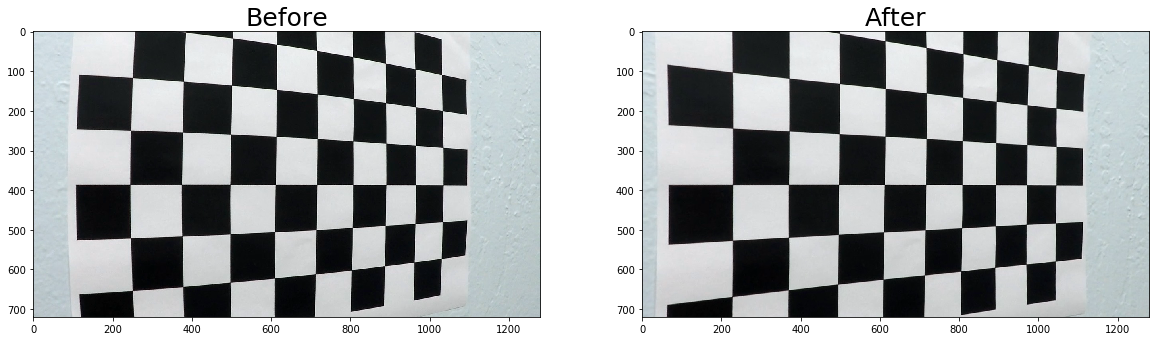

In [8]:
'''
Read a random image
'''
import random

best_image = ["camera_cal/calibration1.jpg",
              "camera_cal/calibration2.jpg",
              "camera_cal/calibration3.jpg",
              "camera_cal/calibration4.jpg",
              "camera_cal/calibration5.jpg"]

distort_image = cv2.imread(random.choice(best_image))

undistorted_image_chessboard = undistorted_image(distort_image)

'''
Display distort_image and undistorted_image
'''
display_image(distort_image, None, undistorted_image_chessboard, None, flag=True, name="chessboard_calibration")

# Pipeline(test images)

### Distortion corrected on road image
### Goal
- [X] Distortion corrected on road line
- [X] Save undistorted image

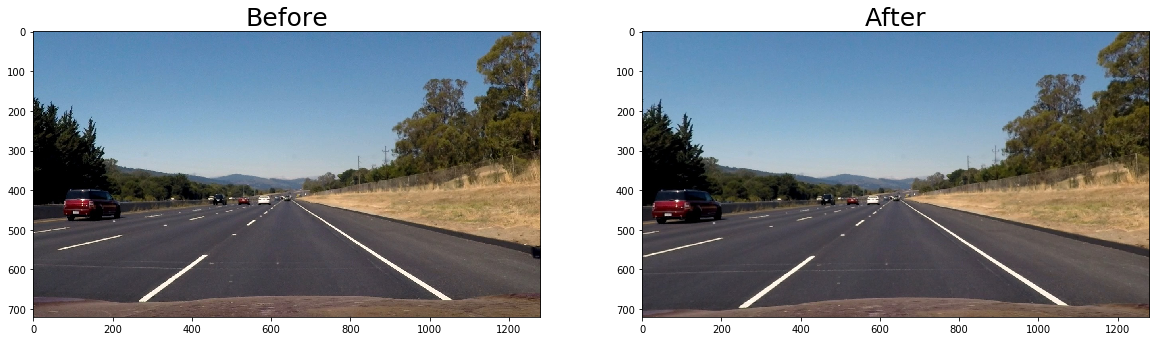

In [9]:
'''
Read a random image
'''
import random

list_of_road_images =  glob.glob("test_images/*.jpg")
assert len(list_of_images) > 0, "list_of_road_images should not be empty, " + str(len(list_of_road_images))

distort_image = cv2.imread(random.choice(list_of_road_images))

undistorted_image_road = undistorted_image(distort_image)

'''
Display distort_image and undistorted_image
'''
display_image(cv2.cvtColor(distort_image, cv2.COLOR_BGR2RGB), None, 
              cv2.cvtColor(undistorted_image_road, cv2.COLOR_BGR2RGB), None, 
              flag=True, name="undistorted_image_road")

# Color transformation
    Calculate color transforms, gradients and other methods to create a thresholded binary image

### Goal
- [X] Calculate directional gradient
- [X] Calculate gradient magnitude
- [X] Calculate gradient direction
- [X] Calculate color threshold
- [X] Combine all threshold

## Calculate directional gradient
    Apply the Sobel x and y operators to image.
    
### Goal
- [X] Convert to gray
- [X] Apply sobel 
- [X] Calculate absolute value
- [X] Calculate threshold

In [10]:
def absolute_sobel_threshold(undistorted_image, orient='x', threshold_minimum=0, threshold_maximum=255):
    '''
    Convert to grayscale
    '''
    gray_image = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2GRAY)
    
    '''
    Apply sobel and calculate absolute value
    '''
    absolute_sobel = np.absolute(cv2.Sobel(gray_image, cv2.CV_64F,
                                           1 if orient == 'x' else 0,
                                           0 if orient == 'x' else 1))
    
    '''
    Rescale back to 8 bit
    '''
    resized_sobel = np.uint8(255 * absolute_sobel/np.max(absolute_sobel))
    
    '''
    Make a copy
    '''
    threshold = np.zeros_like(resized_sobel)
    
    '''
    Apply thresholds max and min
    '''
    threshold[(resized_sobel >= threshold_minimum) & (resized_sobel <= threshold_maximum)] = 1
    
    # return threshold image
    return threshold

### [TESTING] - { absolute_sobel_threshold }

In [11]:
'''
Copy a undistorted_image_road
'''
directional_gradient_image = np.copy(undistorted_image_road)

#### [Test - Sobel X]

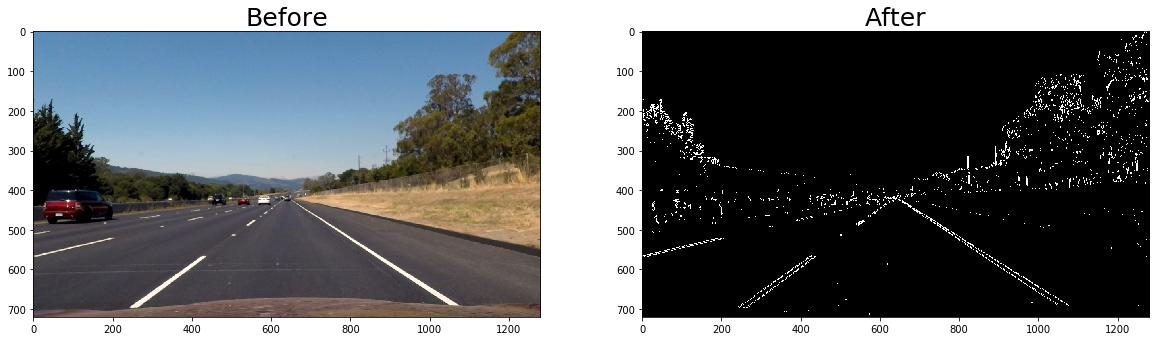

In [12]:
# sobel x test
absolut_sobel_threshold_x_outut = absolute_sobel_threshold(directional_gradient_image, # image
                                                          orient='x',                  # orient
                                                          threshold_minimum=30,        # min 
                                                          threshold_maximum=100)       # max

'''
Display directional_gradient_image and absolut_sobel_threshold_x_outut
'''
display_image(cv2.cvtColor(directional_gradient_image, cv2.COLOR_BGR2RGB), None, 
              absolut_sobel_threshold_x_outut, "gray", 
              flag=True, name="absolut_sobel_threshold_x_outut")

#### [Test - Sobel Y]

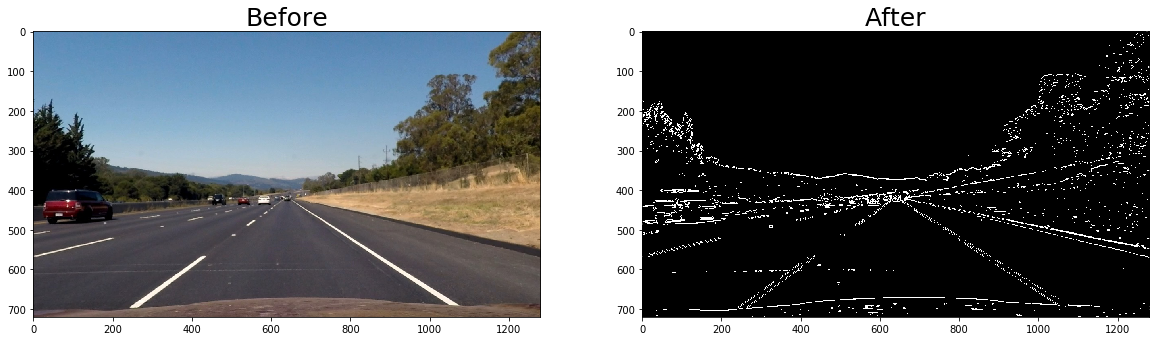

In [13]:
# sobel y test
absolut_sobel_threshold_y_outut = absolute_sobel_threshold(directional_gradient_image, # image
                                                          orient='y',                  # orient
                                                          threshold_minimum=30,        # min 
                                                          threshold_maximum=100)       # max

'''
Display directional_gradient_image and absolut_sobel_threshold_x_outut
'''
display_image(cv2.cvtColor(directional_gradient_image, cv2.COLOR_BGR2RGB), None, 
              absolut_sobel_threshold_y_outut, "gray",
             flag=True, name="absolut_sobel_threshold_y_outut")

## Calculate gradient magnitude
    calculate the magnitude of the gradient and apply threshold

### Goal
- [X] Convert to grayscale
- [X] Apply Sobel
- [X] Calculate gradient magnitude
- [X] Apply threshold

In [14]:
def gradient_magnitude_threshold(undistorted_image, sobel_kernel=3, threshold_minimum=0, threshold_maximum=255):
    '''
    Convert to grayscale
    '''
    gray_image = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2GRAY)
    
    '''
    Apply sobel for x and y
    '''
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    '''
    Calculate gradient magnitude and rescale to 8 bit
    '''
    gradient_magnitude = np.sqrt((sobel_x**2) + (sobel_y**2))
    scale_factor = np.max(gradient_magnitude)/255
    gradient_magnitude = (gradient_magnitude/scale_factor).astype(np.uint8)
    
    '''
    Make a copy
    '''
    threshold = np.zeros_like(gradient_magnitude)
    
    '''
    Apply threshold max and min
    '''
    threshold[(gradient_magnitude >= threshold_minimum) & (gradient_magnitude <= threshold_maximum)] = 1
    
    # return
    return threshold

### [TESTING] - { gradient_magnitude_threshold }

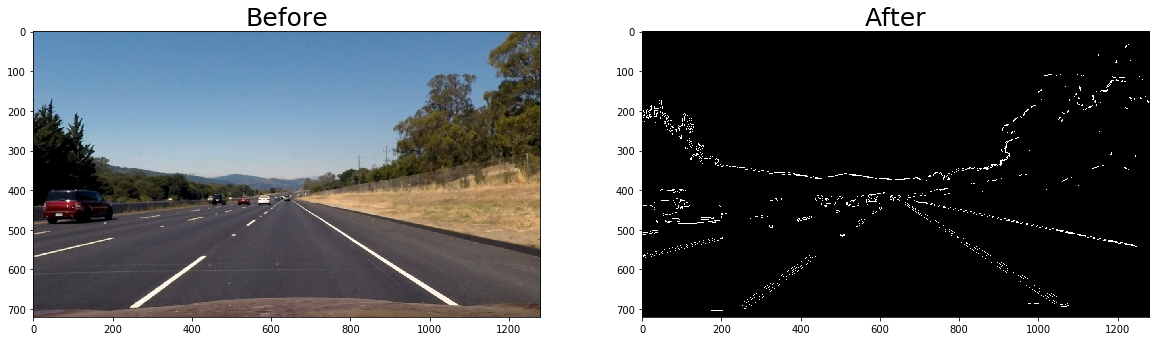

In [15]:
'''
Copy a undistorted_image_road
'''
gradient_magnitude_image = np.copy(undistorted_image_road)

# test gradient_magnitude_threshold
gradient_magnitude_threshold_output = gradient_magnitude_threshold(gradient_magnitude_image,
                                                                  sobel_kernel=15,
                                                                  threshold_minimum=70,
                                                                  threshold_maximum=100)

'''
Display gradient_magnitude_image and gradient_magnitude_threshold_output
'''
display_image(cv2.cvtColor(gradient_magnitude_image, cv2.COLOR_BGR2RGB), None,
             gradient_magnitude_threshold_output, "gray",
             flag=True, name="gradient_magnitude_threshold_output")

## Calculate gradient direction
    calculate the direction of the gradient and apply threshold

### Goal
- [X] Convert to grayscale
- [X] Apply Sobel
- [X] Calculate gradient direction
- [X] Apply threshold

In [16]:
def gradient_direction_threshold(undistorted_image, sobel_kernel=3, threshold_minimum=0, threshold_maximum=255):
    '''
    Convert to grayscale
    '''
    gray_image = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2GRAY)
    
    '''
    Apply sobel in x and y
    '''
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    '''
    Calculate gradient direction
    '''
    absolute_gradient_direction = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    
    '''
    Apply threshold max and min
    '''
    threshold = np.zeros_like(absolute_gradient_direction)
    threshold[(absolute_gradient_direction >= threshold_minimum) & (absolute_gradient_direction <= threshold_maximum)] = 1
    
    # return
    return threshold

### [TESTING] - { gradient_direction_threshold }

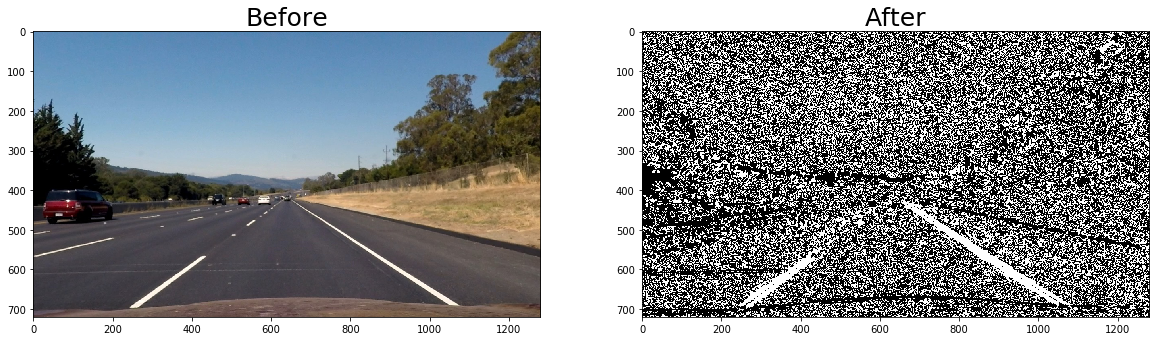

In [17]:
'''
Copy a undistorted_image_road
'''
gradient_direction_image = np.copy(undistorted_image_road)

#test gradient_direction_threshold
gradient_direction_threshold_output = gradient_direction_threshold(gradient_direction_image,
                                                                  sobel_kernel=15,
                                                                  threshold_minimum=0.7,
                                                                  threshold_maximum=1.3)

'''
Display gradient_direction_image and gradient_direction_threshold_output
'''
display_image(cv2.cvtColor(gradient_direction_image, cv2.COLOR_BGR2RGB), None,
             gradient_direction_threshold_output, "gray",
             flag=True, name="gradient_direction_threshold_output")

## Calculate color threshold
    calculate the HSL of the image
    
### Goal
- [X] Convert to HSL
- [X] Select a color channel
- [X] Apply threshold

In [18]:
def color_threshold(undistorted_image, channel='S', threshold_minimum=0, threshold_maximum=255):
    '''
    Convert to HLS
    '''
    HLS_image = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2HLS)
    
    '''
    Select channel 
    '''
    color_channel = None
    
    if channel == 'H':
        color_channel = HLS_image[:,:,0] # H-Channel
    elif channel == 'L':
        color_channel = HLS_image[:,:,1] # L-Channel
    elif channel == 'S':
        color_channel = HLS_image[:,:,2] # S-Channel
    
    '''
    Apply threshold max and min
    '''
    threshold = np.zeros_like(color_channel)
    threshold[(color_channel >= threshold_minimum) & (color_channel <= threshold_maximum)] = 1
    
    # return
    return threshold

## [TESTING] - { color_threshold }

In [19]:
'''
Copy a undistorted_image_road
'''
color_threshold_image = np.copy(undistorted_image_road)

#### [TESTING] - H Channel color

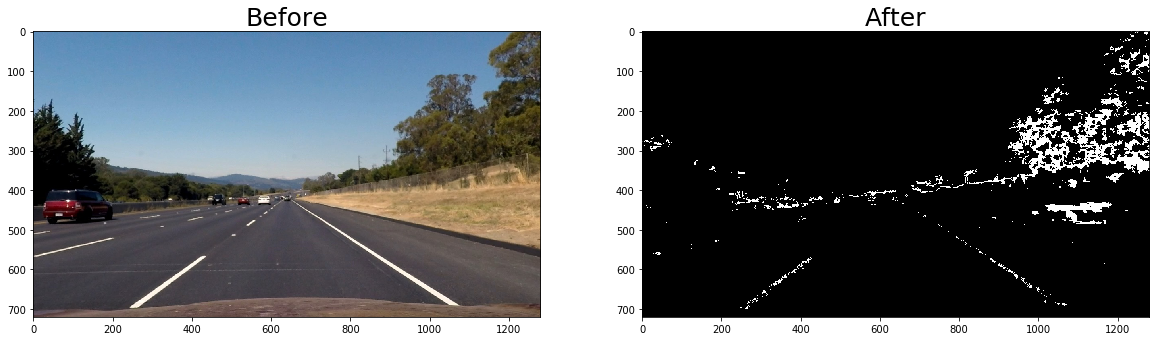

In [20]:
# test color threshold
H_color_channel = color_threshold(color_threshold_image,
                                 channel='H',
                                 threshold_minimum=97,
                                 threshold_maximum=100)

'''
Display color_threshold_image and H_color_channel
'''
display_image(cv2.cvtColor(color_threshold_image, cv2.COLOR_BGR2RGB), None,
             H_color_channel, "gray",
             flag=True, name="H_color_channel")

#### [TESTING] - L Channel color

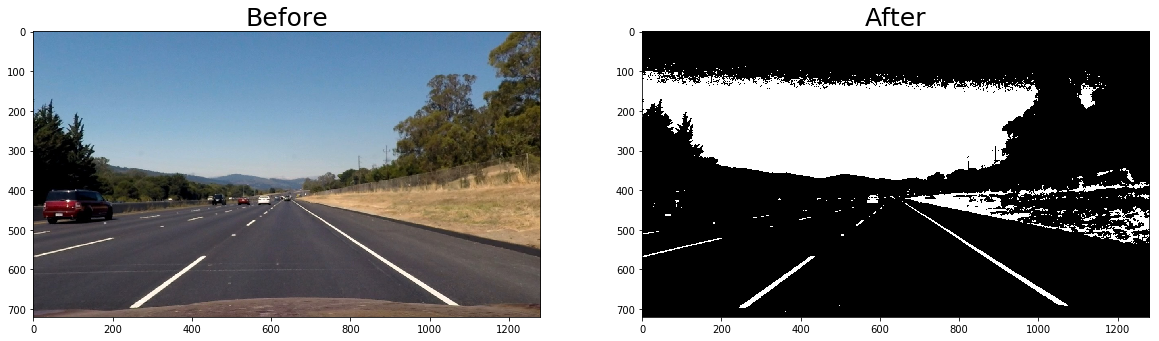

In [21]:
# test color threshold
L_color_channel = color_threshold(color_threshold_image,
                                 channel='L',
                                 threshold_minimum=150,
                                 threshold_maximum=255)

'''
Display color_threshold_image and L_color_channel
'''
display_image(cv2.cvtColor(color_threshold_image, cv2.COLOR_BGR2RGB), None,
             L_color_channel, "gray",
             flag=True, name="L_color_channel")

#### [TESTING] - S Channel color

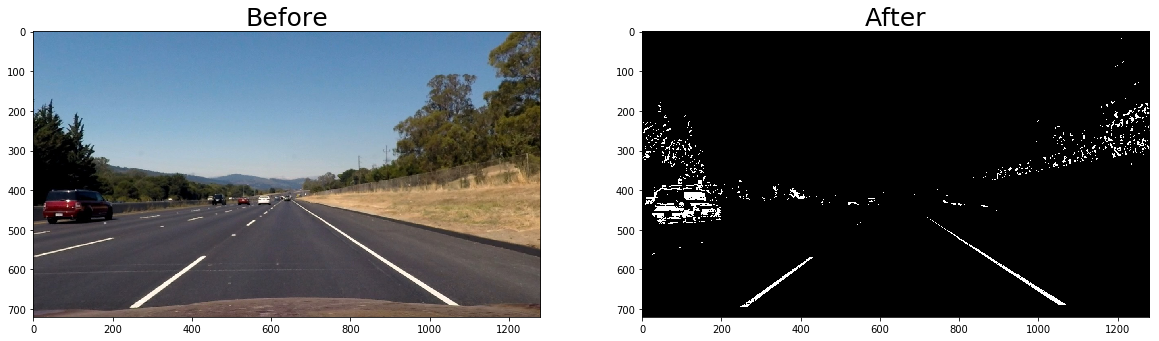

In [22]:
# test color threshold
S_color_channel = color_threshold(color_threshold_image,
                                 channel='S',
                                 threshold_minimum=170,
                                 threshold_maximum=255)

'''
Display color_threshold_image and S_color_channel
'''
display_image(cv2.cvtColor(color_threshold_image, cv2.COLOR_BGR2RGB), None,
             S_color_channel, "gray",
             flag=True, name="S_color_channel")

## Combine all threshold
    combine all the calculated threshold
    
### Goal
- [X] Make a copy
- [X] Combine all threshold

In [23]:
def combine_all_threshold(sobel_x_threshold_, 
                         sobel_y_threshold_,
                         gradient_magnitude_threshold_,
                         gradient_direction_threshold_,
                         color_threshold_,
                         ksize=15):
    '''
    Combine all threshold
    
    threshold = sobel_x + sobel_y + grad_mag + grad_dir + col_threshold
    '''
    combined_threshold = np.zeros_like(gradient_direction_threshold_)
    combined_threshold[((sobel_x_threshold_ == 1) & (sobel_y_threshold_ == 1)) | 
                      ((gradient_magnitude_threshold_ == 1) & (gradient_direction_threshold_ == 1)) |
                      (color_threshold_ == 1)] = 1
    
    # return
    return combined_threshold

### [TESTING] - { combine_all_threshold }

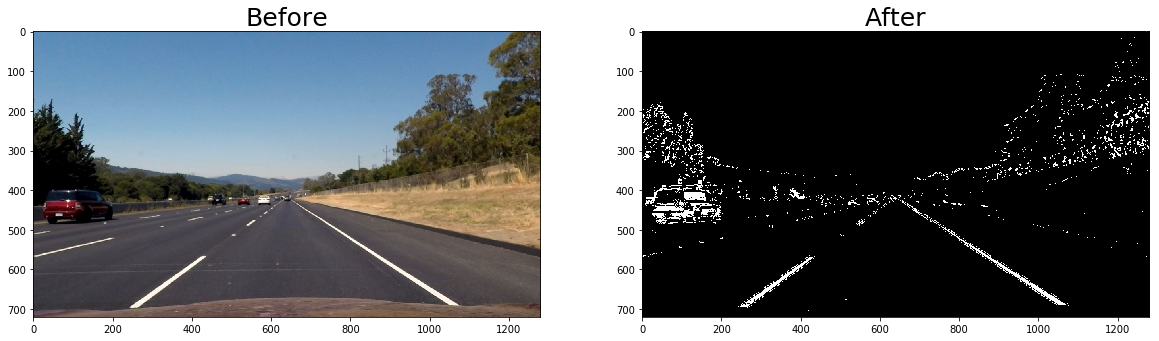

In [24]:
# combine all
combined_threshold = combine_all_threshold(absolut_sobel_threshold_x_outut,
                                           absolut_sobel_threshold_y_outut,
                                           gradient_magnitude_threshold_output,
                                           gradient_direction_threshold_output,
                                           S_color_channel,
                                           ksize=15)

'''
Display final threshold image
'''
display_image(cv2.cvtColor(color_threshold_image, cv2.COLOR_BGR2RGB), None,
             combined_threshold, "gray",
             flag=True, name="combined_threshold")

## Birds-Eye view
    Perspective transform to the image
    
### Goal
- [x] Get image size
- [X] Calculate prespective transform
- [X] Calculate inverse prespective transform
- [x] Wrap perspective transform

In [25]:
def perspective_transform(undistorted_image, source, destination):
    '''
    Get image size
    '''
    image_size = (undistorted_image.shape[1], undistorted_image.shape[0])
    
    '''
    Calculate the perspective transform
    '''
    M = cv2.getPerspectiveTransform(source, destination)
    
    '''
    Calculate the inverse perspective transform
    '''
    Minv = cv2.getPerspectiveTransform(destination, source)
    
    '''
    Wrap perspective transform
    '''
    wrap = cv2.warpPerspective(undistorted_image, M, image_size, flags=cv2.INTER_LINEAR)
    
    return wrap, M, Minv

### [TESTING] - { perspective_transform }

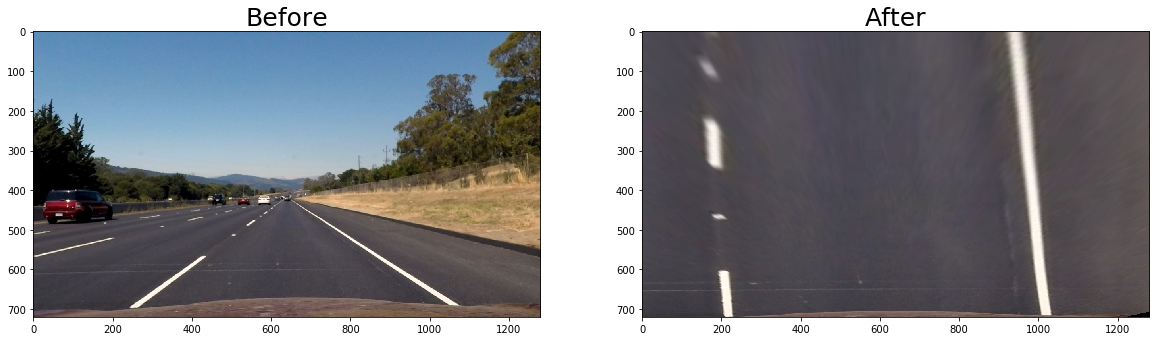

In [26]:
'''
Copy a undistorted_image_road
'''
prespective_transform_image = np.copy(undistorted_image_road)

'''
Source and destination coordiantes in image
'''
source = np.float32([[280, 700], [595, 460], [725, 460], [1125, 700]])
destination = np.float32([[250, 720], [250, 0], [1065, 0], [1065, 720]])

'''
Apply birds-Eye view on image
'''
prespective_transformed_image, _, Minv = perspective_transform(prespective_transform_image, source, destination)

'''
Display prespective_transform_image and prespective_transformed_image
'''
display_image(cv2.cvtColor(prespective_transform_image, cv2.COLOR_BGR2RGB), None,
             cv2.cvtColor(prespective_transformed_image, cv2.COLOR_BGR2RGB), "gray",
             flag=True, name="prespective_transformed_image")

## Identified lane-line pixel
     Identify lane line pixels in the rectified binary image.

### Goal
- [x] Find histogram
- [x] 

### Historam

In [27]:
def histogram(combined_image):
    return np.sum(combined_image[combined_image.shape[0]//2:,:], axis=0)

#### [TESTING] - { histogram }

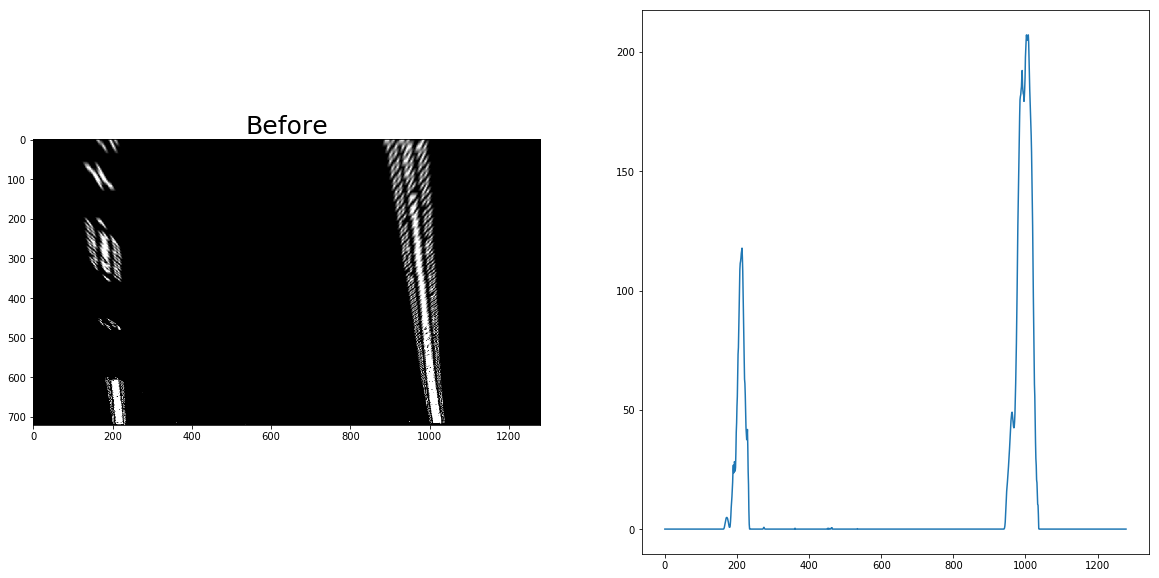

In [28]:
'''
Combined wrap image
'''
source_combined_wrap = np.copy(source)
destination_combined_wrap = np.copy(destination)
combined_threshold_wrap = np.copy(combined_threshold)

'''
Prespective transformation
'''
combined_wrap = perspective_transform(combined_threshold_wrap, source_combined_wrap, destination_combined_wrap)[0]

'''
Apply histogram
'''
histogram_of_wrap_image = histogram(combined_wrap)

'''
Display histogram and save
'''
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    # before image
ax1.imshow(combined_wrap, cmap="gray")
ax1.set_title('Before', fontsize=25)
ax2.plot(histogram_of_wrap_image)
figure.savefig('./output_images/histogram.jpg')

### Sliding window 
    sliding window search for two lanes

### Goal
- [X] Take histogram
- [X] Find the peak
- [X] Identify the x an y
- [X] Draw on image
- [X] Calculate the polynomial

In [29]:
def sliding_window_search(combined_wrap, flag):
    '''
    Calculate the histogram
    '''
    histogram_sliding_window = histogram(combined_wrap)

    '''
    Calculate output image if flag set
    '''
    if flag:
        output_image = np.dstack((combined_wrap, combined_wrap, combined_wrap))*255
        
    '''
    Find the peak, left, right, midpoint
    '''
    midpoint = np.int(histogram_sliding_window.shape[0]//2)
    leftx_base = np.argmax(histogram_sliding_window[:midpoint])
    rightx_base = np.argmax(histogram_sliding_window[midpoint:]) + midpoint
    
    # no of sliding window
    nwindows = 9
    
    # height 
    window_height = np.int(combined_wrap.shape[0]//nwindows)
    
    '''
    Identify the x and y positions
    '''
    nonzero = combined_wrap.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    '''
    update positions
    '''
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    '''
    set margin and minimum no of pixel
    '''
    margin = 100
    minpix = 50
    
    '''
    left and right lane pixel indices
    '''
    left_lane_indices = []
    right_lane_indices = []
    
    '''
    Iterate through windows
    '''
    for window in range(nwindows):
        '''
        identify the boundries in x and y
        '''
        window_y_low = combined_wrap.shape[0] - (window + 1) * window_height
        window_y_high = combined_wrap.shape[0] - window * window_height
        window_leftx_low = leftx_current - margin
        window_leftx_high = leftx_current + margin
        window_rightx_low = rightx_current - margin
        window_rightx_high = rightx_current + margin
        
        '''
        draw in windows in image
        '''
        if flag:
            cv2.rectangle(output_image,(window_leftx_low, window_y_low), (window_leftx_high, window_y_high), (0,0,255), 3) 
            cv2.rectangle(output_image,(window_rightx_low, window_y_low), (window_rightx_high, window_y_high), (0,0,255), 3) 
            
        '''
        calculate the nonzero pixels in x and y
        ''' 
        window_left_indices = ((nonzeroy >= window_y_low) & 
                               (nonzeroy < window_y_high) & 
                               (nonzerox >= window_leftx_low) & 
                               (nonzerox < window_leftx_high)).nonzero()[0]
        
        window_right_indices = ((nonzeroy >= window_y_low) & 
                                (nonzeroy < window_y_high) & 
                                (nonzerox >= window_rightx_low) & 
                                (nonzerox < window_rightx_high)).nonzero()[0]
        
        '''
        Combine indices
        '''
        left_lane_indices.append(window_left_indices)
        right_lane_indices.append(window_right_indices)
        
        # left
        if len(window_left_indices) > minpix:
            leftx_current = np.int(np.mean(nonzerox[window_left_indices]))
        
        # right
        if len(window_right_indices) > minpix:
            rightx_current = np.int(np.mean(nonzerox[window_right_indices]))
            
    '''
    Concatenate array of indices
    '''      
    left_lane_indices = np.concatenate(left_lane_indices)
    right_lane_indices = np.concatenate(right_lane_indices)
        
    '''
    Extract line pixel points
    '''
    leftx = nonzerox[left_lane_indices]
    lefty = nonzeroy[left_lane_indices]
    rightx = nonzerox[right_lane_indices]
    righty = nonzeroy[right_lane_indices]
        
    '''
    Calculate the polynomial
    '''
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, combined_wrap.shape[0]-1, combined_wrap.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    if flag:
        output_image[nonzeroy[left_lane_indices], nonzerox[left_lane_indices]] = [255,255,0]
        output_image[nonzeroy[right_lane_indices], nonzerox[right_lane_indices]] = [0,255,0]
        
        '''
        Draw left and right line
        '''
        for index in range(combined_wrap.shape[0]):
            cv2.circle(output_image, (int(left_fitx[index]), int(ploty[index])), 1, (255,0,0))
            cv2.circle(output_image, (int(right_fitx[index]), int(ploty[index])), 1, (255,0,0))
            
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), output_image.astype(int)
        
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

### [TESTING] - { sliding_window_search }

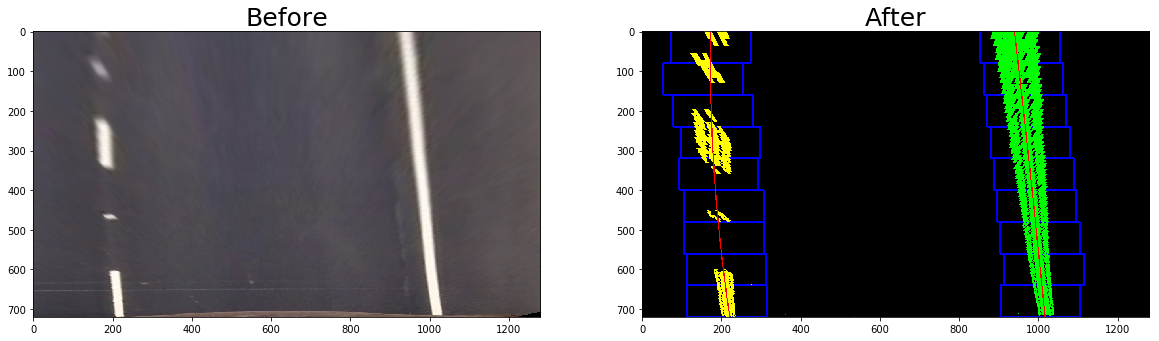

In [30]:
'''
Make copy of combined wrap image
'''
combined_wrap_img = np.copy(combined_wrap)

lines_fit, left_points, right_points, output_image = sliding_window_search(combined_wrap_img, flag=True)

'''
Display result
'''
display_image(cv2.cvtColor(prespective_transformed_image, cv2.COLOR_BGR2RGB), None,
              np.array(output_image, dtype='uint8')[:, :, 0:3], None,
             flag=True, name="sliding_window_search")

## Identify the lane pixel

In [31]:
def detect_lane_pixel(combined_wrap, line_fits=None, flag=False):
    '''
    Check if line fits
    '''
    if line_fits is None:
        return sliding_window_search(combined_wrap, flag)
    
    # split
    left_fit = line_fits[0]
    right_fit = line_fits[1]
    
    '''
    Identify the x and y pixel
    '''
    nonzero = combined_wrap.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    '''
    Width of the window
    '''
    margin = 100
    
    # left lane
    left_lane_indices = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                         (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    
    # right
    right_lane_indices = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                          (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    '''
    Extract of pixel position
    '''
    leftx = nonzerox[left_lane_indices]
    lefty = nonzeroy[left_lane_indices]
    rightx = nonzerox[right_lane_indices]
    righty = nonzeroy[right_lane_indices]
    
    '''
    if lines not found, then exec sliding window search
    '''
    if (leftx.size == 0 or rightx.size == 0):
        return sliding_window_search(combined_wrap, flag)
    
    '''
    calculate the polynomial
    '''
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    '''
    Calculate x and y plotting value
    '''
    ploty = np.linspace(0, combined_wrap.shape[0]-1, combined_wrap.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if flag:
        '''
        Create a image so we can draw in it
        '''
        output_image = np.dstack((combined_wrap, combined_wrap, combined_wrap))*255
        window_image = np.zeros_like(output_image)
        
        '''
        Calculate polygon for the search window
        '''
        # left
        left_line_window_one = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window_two = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window_one, left_line_window_two))
        
        #right
        right_line_window_one = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window_two = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window_one, right_line_window_two))
        
        '''
        Draw on the lane
        '''
        cv2.fillPoly(window_image, np.int_([left_line_pts]), (255,255,255))
        cv2.fillPoly(window_image, np.int_([right_line_pts]), (255,255,255))
        output_image = cv2.addWeighted(output_image, 1, window_image, 0.3, 0)
        
        # add color
        output_image[nonzeroy[left_lane_indices], nonzerox[left_lane_indices]] = [255,255,0]
        output_image[nonzeroy[right_lane_indices], nonzerox[right_lane_indices]] = [0,255,0]
        
        '''
        Draw circle in output_image
        '''
        for index in range(combined_wrap.shape[0]):
            cv2.circle(output_image, (int(left_fitx[index]), int(ploty[index])), 3, (255,0,0))
            cv2.circle(output_image, (int(right_fitx[index]), int(ploty[index])), 3, (255,0,0))
            
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), output_image.astype(int)
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

### [TESTING] - { detect_lane_pixel }

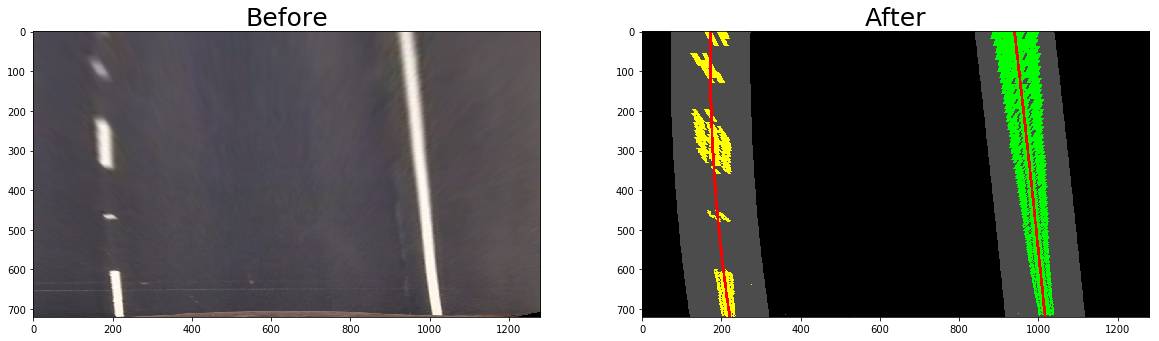

In [32]:
'''
Make copy of combined wrap image
'''
combined_wrap_img = np.copy(combined_wrap)

lines_fit, left_points, right_points, output_image = detect_lane_pixel(combined_wrap_img, lines_fit, flag=True)

'''
Display result
'''
display_image(cv2.cvtColor(prespective_transformed_image, cv2.COLOR_BGR2RGB), None,
              np.array(output_image, dtype='uint8')[:, :, 0:3], None,
             flag=True, name="detec_lane_line")

## Calculation of radius of curvature
    calculating lane line road curving 

### Goal
- [X] Calculate the polynomial to pixel
- [X] Conversion of x and y 
- [X] Calculate polynomial in world space
- [X] Calculate the radius of curvature
- [X] Convert radius to meters

In [33]:
def radius_of_curvature(leftx, rightx, image_shape, xm_per_pixel = np.pi/800, ym_per_pixel = 25/720):
    #cal a poly
    ploty = np.linspace(0, image_shape[0]-1, image_shape[0])
    
    #left
    leftx = leftx[::-1]
    
    #right
    rightx = rightx[::-1]
    
    '''
    Calculate the polynomial to pixel
    '''
    #left
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    
    #right
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    '''
    Conversion of x and y
    '''
    # meter per pixel in y
    ym_per_pixel = 25/720
    
    # meter per pixel in x
    xm_per_pixel = 3.7/800
    
    '''
    Calculate new polynomials
    '''
    y_eval = np.max(ploty)
    left_fit_curuve = np.polyfit(ploty*ym_per_pixel, leftx*xm_per_pixel, 2)
    right_fit_curuve = np.polyfit(ploty*ym_per_pixel, rightx*xm_per_pixel, 2)
    
    '''
    Calculate the radius of curvature
    '''
    left_curvature = ((1 + (2*left_fit_curuve[0]*y_eval*ym_per_pixel + left_fit_curuve[1])**2)**1.5)/np.absolute(2*left_fit_curuve[0])
    right_curvature = ((1 + (2*right_fit_curuve[0]*y_eval*ym_per_pixel + right_fit_curuve[1])**2)**1.5)/np.absolute(2*right_fit_curuve[0])
    
    '''
    Convert radius to meter
    '''
    meter = (left_curvature, right_curvature)
    
    return meter

### [TESTING] - { radius_of_curvature }

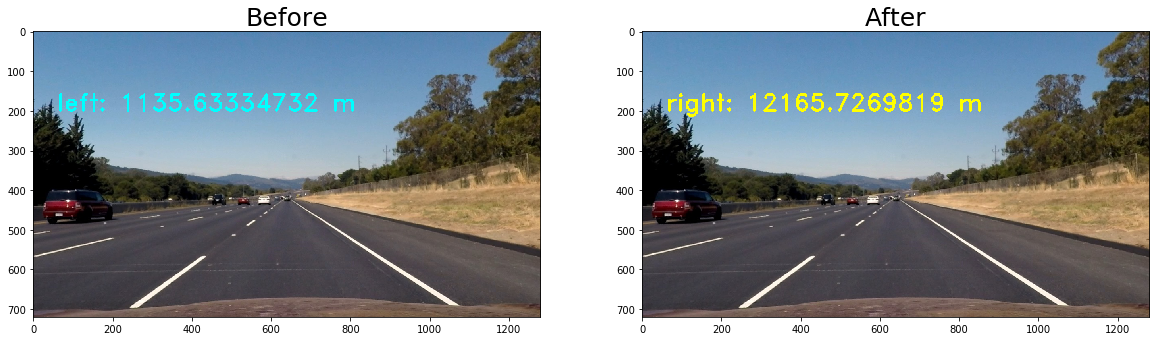

In [34]:
'''
Make copy of combined wrap image
'''
radius_image_left = np.copy(undistorted_image_road)
radius_image_right = np.copy(undistorted_image_road)

'''
Calculate the radius
'''
curvature_radius = radius_of_curvature(leftx=left_points[0], rightx=right_points[0], image_shape=radius_image_left.shape)

'''
Display the radius
'''
cv2.putText(radius_image_left,"left: "+str(curvature_radius[0])+" m",(60, 200), cv2.FONT_HERSHEY_DUPLEX , 2, (255,255,0), 3)
cv2.putText(radius_image_right,"right: "+str(curvature_radius[1])+" m",(60, 200), cv2.FONT_HERSHEY_DUPLEX, 2, (0,255,255), 3)
save_image(radius_image_left, "radius_image_left", None)
save_image(radius_image_right, "radius_image_right", None)
display_image(cv2.cvtColor(radius_image_left, cv2.COLOR_BGR2RGB), None, cv2.cvtColor(radius_image_right, cv2.COLOR_BGR2RGB), None)

### Car offset

In [35]:
'''
Calculate the car offset
'''
def offset(leftx, rightx, image_shape, xm_per_pixel=3.7/800):
    # horizontal position
    middle_image_x = image_shape[1]/2
    
    # car position
    car_position = (leftx[-1] + rightx[-1])/2
    
    # car offset
    offsetx = (middle_image_x - car_position) * xm_per_pixel
    
    return offsetx

### [TESTING] - { offset }

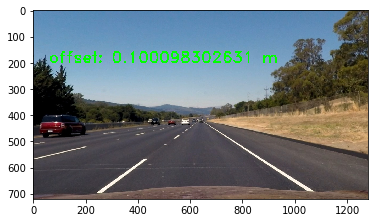

In [36]:
'''
Make copy of combined wrap image
'''
offset_image = np.copy(undistorted_image_road)

offsetx = offset(leftx=left_points[0], rightx=right_points[0], image_shape=offset_image.shape)

'''
Display the offset_image
'''
cv2.putText(offset_image,"offset: "+str(offsetx)+" m",(60, 200), cv2.FONT_HERSHEY_DUPLEX, 2, (0,255,0), 3)
save_image(offset_image, "offset_image", None)
plt.imshow(cv2.cvtColor(offset_image, cv2.COLOR_BGR2RGB))

##  Identify the lane boundaries
    mark calcualted points in image
### Goal
- [X] Create a empty image
- [X] Mark the points on image
- [X] Combine the image

In [37]:
def draw_lane_line(image, warped_image, left_points, right_points, Minv):
    # make a image
    warped_image = np.zeros_like(warped_image).astype(np.uint8)
    color_wrap = np.dstack((warped_image, warped_image, warped_image))
    
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]
    
    points_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    points_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    points = np.hstack((points_left, points_right))
    
    '''
    Draw the line in lane on image
    '''
    cv2.fillPoly(color_wrap, np.int_([points]), LANE_BGR)
    
    '''
    Combine warp image to original image
    '''
    new_image = cv2.warpPerspective(color_wrap, Minv, (image.shape[1], image.shape[0]))
    return cv2.addWeighted(image, 1, new_image, 0.3, 0)

### [TESTING] - { draw_lane_line }

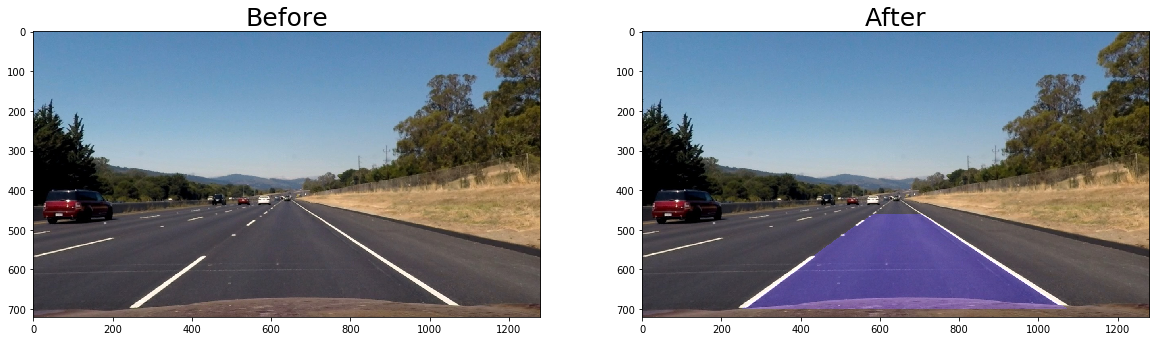

In [38]:
'''
Make copy of combined wrap image
'''
normal_image = np.copy(undistorted_image_road)
warp_image = np.copy(combined_wrap)

image_lane = draw_lane_line(normal_image, warp_image, left_points, right_points, Minv)

'''
Display processed image
'''
display_image(cv2.cvtColor(normal_image, cv2.COLOR_BGR2RGB), None, 
              cv2.cvtColor(image_lane, cv2.COLOR_BGR2RGB), None,
             flag=True, name="draw_lane_line")

## Display values
     values like curvature, offset

### Goal
- [X] Calculate the radius
- [X] Mark in image

In [39]:
def display_values(image, leftx, rightx, xm_per_pixel=3.7/800, ym_per_pixel=25/720):
    '''
    Calculate the radius of curvature
    '''
    curvature_of_radius = radius_of_curvature(leftx=leftx, rightx=rightx, image_shape=image.shape, xm_per_pixel=xm_per_pixel, ym_per_pixel=ym_per_pixel)
    
    '''
    Calculate the offset
    '''
    offsetx = offset(leftx=leftx, rightx=rightx, image_shape=offset_image.shape)
    
    '''
    Mark in image
    '''
    final_image = np.copy(image)
    
    cv2.putText(final_image, ("Left Lane: "+str(curvature_of_radius[0])+" m"), (60,60), cv2.FONT_HERSHEY_DUPLEX, 1.8, (255,255,0), 3)
    cv2.putText(final_image, ("Right Lane: "+str(curvature_of_radius[1])+" m"), (60,140), cv2.FONT_HERSHEY_DUPLEX, 1.8, (0,255,255), 3)
    cv2.putText(final_image, ("Offset: "+str(offsetx)+" m"), (60,220), cv2.FONT_HERSHEY_DUPLEX, 1.8, (0,255,0), 3)
    
    return final_image

### [[TESTING]] - { display_values }

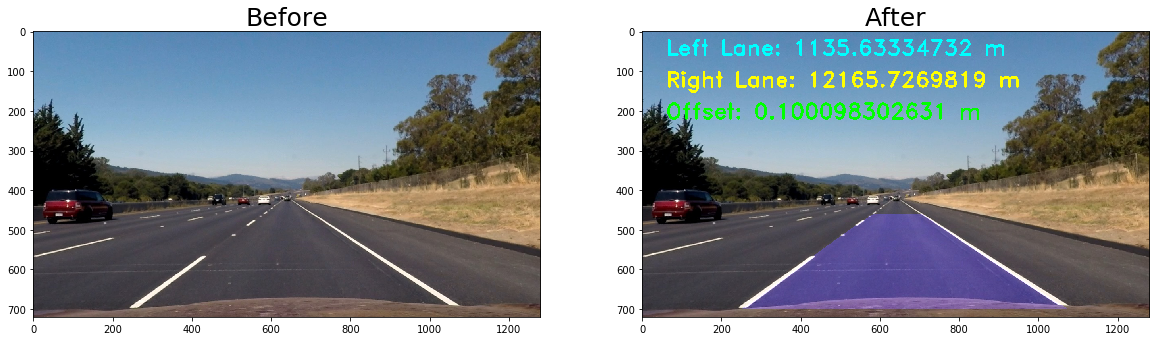

In [40]:
'''
Make copy of image
'''
normal_image = np.copy(image_lane)

final_image = display_values(normal_image, leftx=left_points[0], rightx=right_points[0])

'''
Display processed image
'''
display_image(cv2.cvtColor(undistorted_image_road, cv2.COLOR_BGR2RGB), None, 
              cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB), None,
             flag=True, name="display_values")

## Pipeline
    run video as image

### Goal
- [X] Calibrate camera
- [X] Undistord image
- [X] Calculate directional gradient
- [X] Calculate gradient magnitude 
- [X] Calculate gradient direction
- [X] Calculate color threshold
- [X] Add all threshold
- [X] Apply a perspective transform
- [X] Detected lane
- [X] Display values

In [41]:
def pipeline(image):
    '''
    Undistord image
    '''
    image = undistorted_image(image)
    
    '''
    Calculate directional gradient
    '''
    gradient_image_x = absolute_sobel_threshold(image, orient='x', threshold_minimum=30, threshold_maximum=100)
    gradient_image_y = absolute_sobel_threshold(image, orient='y', threshold_minimum=30, threshold_maximum=100)
    
    '''
    Calcualte gradient magnitude
    '''
    magnitude_image = gradient_magnitude_threshold(image, sobel_kernel=15, threshold_minimum=70, threshold_maximum=100)
    
    '''
    Calculate gradient direction
    '''
    direction_image = gradient_direction_threshold(image, sobel_kernel=15, threshold_minimum=0.7, threshold_maximum=1.3)
    
    '''
    Calcualte the color threshold
    '''
    color_image = color_threshold(color_threshold_image, channel='S', threshold_minimum=170, threshold_maximum=255)
    
    '''
    Combined all 
    '''
    combined_image = combine_all_threshold(gradient_image_x,
                                           gradient_image_y,
                                           magnitude_image,
                                           direction_image,
                                           color_image,
                                           ksize=15)
    
    '''
    Birds view
    '''
    source_c = np.copy(source)
    destination_c = np.copy(destination)
    combined_wrap, _, Minv = perspective_transform(combined_image, source_c, destination_c)
    
    '''
    Detect lines
    '''
    lines_fit = None
    lines_fit, left_points, right_points, final_image = detect_lane_pixel(combined_wrap, lines_fit, flag=True)
    
    '''
    Draw lanes
    '''
    image_lines = draw_lane_line(image, combined_wrap, left_points, right_points, Minv)
    
    '''
    Add values
    '''
    final_image = display_values(image_lines, leftx=left_points[0], rightx=right_points[0])
    
    return final_image

# Test Video

In [42]:
!pip install imageio-ffmpeg
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

  Running setup.py bdist_wheel for imageio-ffmpeg ... done
  Stored in directory: /root/.cache/pip/wheels/54/ed/2d/4281f5e6a575bfaa7d8f1f4173a7cb635adc406c1f8d87bfc8
Successfully built imageio-ffmpeg


In [43]:
def process_image(image):
    result = pipeline(image)
    return result

In [44]:
white_output = 'test_videos_output/solution.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solution.mp4
[MoviePy] Writing video test_videos_output/solution.mp4


100%|█████████▉| 1260/1261 [08:59<00:00,  2.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solution.mp4 

CPU times: user 6min 4s, sys: 34.6 s, total: 6min 38s
Wall time: 9min 2s


### [Note] to change lane color, modify LANE_BGR at begining. 

### Color difference due to which I read image using cv2 which is BGR but video share with RGB.

In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))